# Homework 7

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-13

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on following symbology & data files, as of 2024-12-13.

USD cash bonds:
- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,

SOFR OIS swaps:
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.

CDX Index:
- the CDX Index symbology file (for hyg basket) `cdx_symbology`,
- the CDX Index basket composition file `cdx_basket_composition`,


In [1]:
import datetime
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')
today = pd.to_datetime("2024-12-13") 
days_per_year = 365.25

In [2]:
# Load bond_symbology
bond_symbology = pd.read_excel("data/bond_symbology.xlsx")
bond_symbology['start_date'] = pd.to_datetime(bond_symbology['start_date'])
bond_symbology['cpn_first'] = pd.to_datetime(bond_symbology['cpn_first'])
bond_symbology['acc_first'] = pd.to_datetime(bond_symbology['acc_first'])
bond_symbology['maturity'] = pd.to_datetime(bond_symbology['maturity'])

bond_symbology['term'] = ((bond_symbology['maturity'] - bond_symbology['start_date']).dt.days / days_per_year)
bond_symbology['TTM'] = ((bond_symbology['maturity'] - today).dt.days / days_per_year)
bond_symbology['TTM'] = bond_symbology['TTM'].apply(lambda x: x if x > 0 else 0)
bond_symbology.head()

,ticker,class,figi,isin,und_bench_tsy_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.001369,18.387406
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.001369,19.394935
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.158795
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2015-05-13,2045-05-13,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.413415
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2016-02-23,2026-02-23,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV,10.001369,1.196441


In [3]:
# Load bond_market_prices_eod
bond_market_prices_eod = pd.read_excel("data/bond_market_prices_eod.xlsx")
bond_market_prices_eod["date"] = pd.to_datetime(bond_market_prices_eod["date"])
bond_market_prices_eod["midPrice"] = (bond_market_prices_eod["bidPrice"] + bond_market_prices_eod["askPrice"])/2
bond_market_prices_eod["midYield"] = (bond_market_prices_eod["bidYield"] + bond_market_prices_eod["askYield"])/2
display(bond_market_prices_eod.head())

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132,93.5185,5.1560
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194,63.9775,5.2180
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205,63.9655,5.2290
3,2024-12-13,Corp,AAPL,US037833EF38,BBG00Z3VQ626,63.262,63.766,0.9420,5.249,5.200,63.5140,5.2245
4,2024-12-13,Corp,AAPL,US037833CD08,BBG00DHQX9M5,82.278,82.848,1.4120,5.227,5.177,82.5630,5.2020


In [4]:
# Load govt_on_the_run
govt_on_the_run = pd.read_excel("data/govt_on_the_run.xlsx")
on_the_run_list = ["2Y","3Y","5Y","7Y","10Y","20Y","30Y"]
pattern = r"^GT(\d+)([A-Z])?\sGovt$"
govt_on_the_run[["tenor", "suffix"]] = govt_on_the_run["ticker"].str.extract(pattern)
govt_on_the_run["tenor"] = govt_on_the_run["tenor"] + "Y"
display(govt_on_the_run.head())

,ticker,date,figi,isin,tenor,suffix
0,GT10 Govt,2024-12-13,BBG01QKHSMP5,US91282CLW90,10Y,NaN
1,GT10B Govt,2024-12-13,BBG01P1YBJQ5,US91282CLF67,10Y,B
2,GT10C Govt,2024-12-13,BBG01MPC8VJ9,US91282CKQ32,10Y,C
3,GT2 Govt,2024-12-13,BBG01QZFYJV6,US91282CLY56,2Y,NaN
4,GT20 Govt,2024-12-13,BBG01QVTC1Y0,US912810UF39,20Y,NaN


In [5]:
# Load sofr_swaps_symbology
sofr_sym = pd.read_excel('data/sofr_swaps_symbology.xlsx')
sofr_sym.head()

,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
4,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV


In [6]:
# Load sofr_swaps_market_data_eod
sofr_mkt = pd.read_excel('data/sofr_swaps_market_data_eod.xlsx')
sofr_mkt['date'] = pd.to_datetime(sofr_mkt['date'])
sofr_mkt.head()

,date,figi,bidRate,askRate,midRate
0,2024-01-02,BBG00KFWPJJ9,4.7960,4.8046,4.80030
1,2024-01-02,BBG00KFWPJX3,4.1368,4.1452,4.14100
2,2024-01-02,BBG00KFWPK15,3.8258,3.8327,3.82925
3,2024-01-02,BBG00KFWPK51,3.5907,3.5943,3.59250
4,2024-01-02,BBG00KFWPK79,3.5297,3.5333,3.53150


-----------------------------------------------------------
# Problem 1: Pricing bonds in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

## a. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%

Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.


We model equity as a European call on the firm’s assets

- Leverage
  $
    \text{Leverage}
    = \frac{L}{A_0}
    = \frac{100}{125}
    = 0.80.
  $
- Book Value of Equity
  $
    \text{BVE} = A_0 - L = 125 - 100 = 25\ \text{MM}.
  $
- Fair Value of Equity
  $
  E_0 = A_0\,\Phi(d_1) - K\,e^{-rT}\,\Phi(d_2), 
  \quad
    d_{1,2}
      = \frac{\ln(A_0/K) + (r \pm \tfrac12\sigma_A^2)\,T}{\sigma_A\sqrt T}, 
  $

In [7]:
A0 = 125.0        
L = 100.0        
T = 5.0         
r = 0.04      
sigma_A = 0.20  
K = L       

In [8]:
leverage = L / A0
bve = A0 - L
print(f"Leverage = L/A0 = {L:.1f}/{A0:.1f} = {leverage:.2f}")
print(f"Book Value of Equity = A0 – L = {A0:.1f} – {L:.1f} = {bve:.1f} MM")

Leverage = L/A0 = 100.0/125.0 = 0.80
Book Value of Equity = A0 – L = 125.0 – 100.0 = 25.0 MM


In [9]:
d1 = (np.log(A0/K) + (r + 0.5*sigma_A**2)*T) / (sigma_A*np.sqrt(T))
d2 = d1 - sigma_A*np.sqrt(T)
E0 = A0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
print(f"d1 = {d1:.4f}, d2 = {d2:.4f}")
print(f"Fair value of equity E0 = {E0:.2f} MM")

d1 = 1.1698, d2 = 0.7226
Fair value of equity E0 = 47.23 MM


## b. Risky Bond Valuation (Fair Value of Liabilities)

Compute the fair value of the risky bond.

By no‐arbitrage the debt value is
$
  B_0 = A_0 - E_0.
$

In [10]:
B0 = A0 - E0
print(f"Fair value of risky bond B0 = A0 – E0 = {A0:.2f} – {E0:.2f} = {B0:.2f} MM")

Fair value of risky bond B0 = A0 – E0 = 125.00 – 47.23 = 77.77 MM


## c. Flat yield, spread and hazard rate

Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default

Plot separate charts for 
- Bond Credit Spreads and 
- Expected Recovery on Defaults

as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

For $A_0 \in \{50,55,\dots,200\}$ MM compute:

1. Distance to Default: $d_2$.  
2. Default Probability: $\Phi(-d_2)$.  
3. Bond Yield $y = -\frac1T\ln(B_0/K)$, Spread $s=(y-r)\times10^4$ (bps). 
4. Flat Hazard Rate: $h = -\tfrac1T\ln(\Phi(d_2))$.  
5. Expected Recovery: $R_{\rm exp} = \frac{A_0\,\Phi(-d_1)}{K\,\Phi(-d_2)}$.

In [11]:
grid = np.arange(50, 205, 5)
records = []
for A in grid:
    d1g = (np.log(A/K) + (r + 0.5*sigma_A**2)*T) / (sigma_A*np.sqrt(T))
    d2g = d1g - sigma_A*np.sqrt(T)
    # Fair debt value
    Bg = A * norm.cdf(-d1g) + K * np.exp(-r*T) * norm.cdf(d2g)
    yg = -np.log(Bg/K)/T
    spread = (yg - r)*1e4 # bps
    hazard = -np.log(norm.cdf(d2g))/T
    recov = (A * norm.cdf(-d1g)) / (K * norm.cdf(-d2g))
    records.append((A, spread, recov))

df = pd.DataFrame(records, columns=["Asset", "Spread_bps", "ExpRecovery"])
display(df.head())

,Asset,Spread_bps,ExpRecovery
0,50,1064.658980,0.446396
1,55,908.829212,0.473956
2,60,775.888031,0.498014
3,65,662.486141,0.519012
4,70,565.774740,0.537375


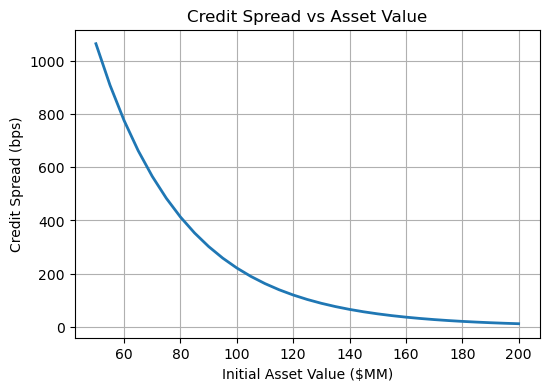

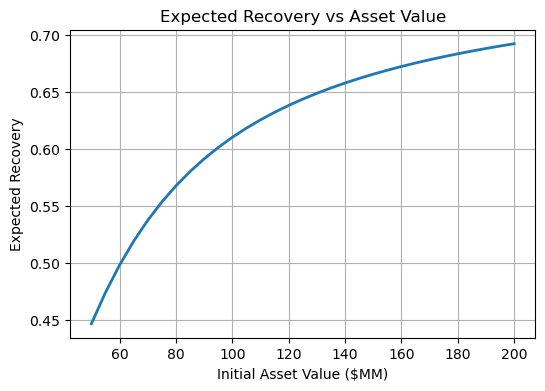

In [12]:
# Credit Spread vs Asset
plt.figure(figsize=(6,4))
plt.plot(df["Asset"], df["Spread_bps"], linewidth=2)
plt.xlabel("Initial Asset Value ($MM)")
plt.ylabel("Credit Spread (bps)")
plt.title("Credit Spread vs Asset Value")
plt.grid(True)
plt.show()

#  Expected Recovery vs Asset
plt.figure(figsize=(6,4))
plt.plot(df["Asset"], df["ExpRecovery"], linewidth=2)
plt.xlabel("Initial Asset Value ($MM)")
plt.ylabel("Expected Recovery")
plt.title("Expected Recovery vs Asset Value")
plt.grid(True)
plt.show()

## d. Equity volatility

Compute the Equity Volatility.

What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?

Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

 

Equity volatility:
$
  \sigma_E
    = \frac{\partial E_0}{\partial A_0}\,\frac{A_0}{E_0}\,\sigma_A
    = \Phi(d_1)\,\frac{A_0}{E_0}\,\sigma_A.
$

In [13]:
vols = []
for A, _, _ in records:
    d1g = (np.log(A/K) + (r + 0.5*sigma_A**2)*T) / (sigma_A*np.sqrt(T))
    E_ = A * norm.cdf(d1g) - K * np.exp(-r*T) * norm.cdf(d1g - sigma_A*np.sqrt(T))
    sigma_E = norm.cdf(d1g) * (A/E_) * sigma_A
    vols.append((A, sigma_E))

vdf = pd.DataFrame(vols, columns=["Asset", "EquityVol"])
display(vdf.head())

,Asset,EquityVol
0,50,0.987245
1,55,0.918834
2,60,0.858721
3,65,0.805566
4,70,0.758317


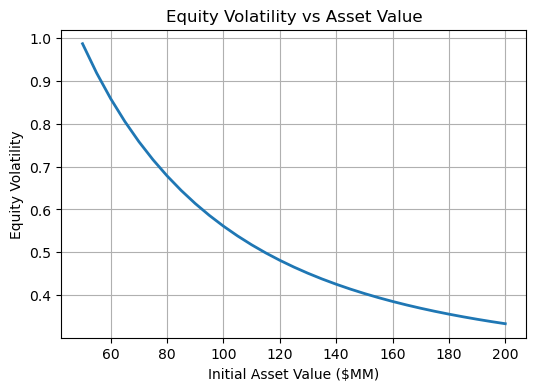

In [14]:
# Equity Volatility vs Asset
plt.figure(figsize=(6,4))
plt.plot(vdf["Asset"], vdf["EquityVol"], linewidth=2)
plt.xlabel("Initial Asset Value ($MM)")
plt.ylabel("Equity Volatility")
plt.title("Equity Volatility vs Asset Value")
plt.grid(True)
plt.show()

Equity volatility declines as asset value increases

-----------------------------------------------------------
# Problem 2: LQD ETF basket analysis - bucketed interest rate hedging

## a. Load and explore the LQD basket composition and market data

Load the `lqd_basket_composition` Excel file into a dataframe. It contains the LQD basket constituent face notionals, weights and yields-to-maturities as of 2024-12-13.

Load the `lqd_corp_symbology` Excel file into a dataframe. It contains the corporate bond details for LQD constituents.

How many corporate bonds are in the LQD basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the LQD basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [15]:
lqd_basket = pd.read_excel('data/lqd_basket_composition.xlsx', parse_dates=['date','maturity'])
lqd_basket.drop(columns='coupon', inplace=True)
lqd_basket.head()

,date,etf_ticker,figi,isin,security,description,maturity,cpn_type,class,currency,bidYield,askYield,midYield,face_notional,face_notional_weight
0,2024-12-13,LQD,BBG00FBCKY28,US002824BG43,ABT 4 3/4 11/30/36,ABBOTT LABORATORIES 4.75 11/30/2036 (SENIOR),2036-11-30,FIXED,Corp,USD,4.987,4.930,4.9585,12742000,0.039595
1,2024-12-13,LQD,BBG00FBCKY37,US002824BH26,ABT 4.9 11/30/46,ABBOTT LABORATORIES 4.9 11/30/2046 (SENIOR),2046-11-30,FIXED,Corp,USD,5.261,5.200,5.2305,22618000,0.070283
2,2024-12-13,LQD,BBG01KWNSJK4,US00774MBJ36,AER 5.1 01/19/29,AERCAP IRELAND CAPITAL DAC 5.1 01/19/2029 (SEN...,2029-01-19,FIXED,Corp,USD,4.973,4.909,4.9410,9558000,0.029701
3,2024-12-13,LQD,BBG007NHSDH4,US023135AQ91,AMZN 4.95 12/05/44,AMAZON.COM INC 4.95 12/05/2044 (SENIOR),2044-12-05,FIXED,Corp,USD,5.134,5.085,5.1095,15383000,0.047801
4,2024-12-13,LQD,BBG010Z2TK09,US023135CC87,AMZN 3 1/4 05/12/61,AMAZON.COM INC 3.25 05/12/2061 (SENIOR),2061-05-12,FIXED,Corp,USD,5.300,5.239,5.2695,11914000,0.037022


In [16]:
lqd_corp = pd.read_excel('data/lqd_corp_symbology.xlsx', parse_dates=['start_date','cpn_first','acc_first','maturity'])
lqd_corp.head()

,ticker,class,figi,isin,und_bench_tsy_isin,security,name,type,coupon,(No column name),...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
0,A,Corp,BBG00ZHZ78P4,US00846UAN19,US91282CLW90,A 2.3 03/12/31,AGILENT TECHNOLOGIES INC,GLOBAL,2.30,FIXED,...,2021-03-12,2021-09-12,2021-03-12,2031-03-12,CALLABLE,Sr Unsecured,850.0,US,USD,ACTV
1,AAPL,Corp,BBG01GKRFG36,US037833ET32,US91282CMA61,AAPL 4 05/10/28,APPLE INC,GLOBAL,4.00,FIXED,...,2023-05-10,2023-11-10,2023-05-10,2028-05-10,CALLABLE,Sr Unsecured,1500.0,US,USD,ACTV
2,AAPL,Corp,BBG011ZS1T38,US037833EH93,US91282CMA61,AAPL 1.4 08/05/28,APPLE INC,GLOBAL,1.40,FIXED,...,2021-08-05,2022-02-05,2021-08-05,2028-08-05,CALLABLE,Sr Unsecured,2300.0,US,USD,ACTV
3,AAPL,Corp,BBG0191F26Z0,US037833EN61,US91282CMA61,AAPL 3 1/4 08/08/29,APPLE INC,GLOBAL,3.25,FIXED,...,2022-08-08,2023-02-08,2022-08-08,2029-08-08,CALLABLE,Sr Unsecured,1000.0,US,USD,ACTV
4,AAPL,Corp,BBG00Q5L6G53,US037833DP29,US91282CMA61,AAPL 2.2 09/11/29,APPLE INC,GLOBAL,2.20,FIXED,...,2019-09-11,2020-03-11,2019-09-11,2029-09-11,CALLABLE,Sr Unsecured,1750.0,US,USD,ACTV


In [17]:
common_cols = set(lqd_basket.columns).intersection(lqd_corp.columns) - {'isin'}
lqd_basket_trim = lqd_basket.drop(columns=list(common_cols))
ldq = lqd_basket_trim.merge(lqd_corp, on='isin', how='inner')
ldq.head()

,date,etf_ticker,isin,description,cpn_type,bidYield,askYield,midYield,face_notional,face_notional_weight,...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
0,2024-12-13,LQD,US002824BG43,ABBOTT LABORATORIES 4.75 11/30/2036 (SENIOR),FIXED,4.987,4.930,4.9585,12742000,0.039595,...,2016-11-22,2017-05-30,2016-11-22,2036-11-30,CALLABLE,Sr Unsecured,1650.0,US,USD,ACTV
1,2024-12-13,LQD,US002824BH26,ABBOTT LABORATORIES 4.9 11/30/2046 (SENIOR),FIXED,5.261,5.200,5.2305,22618000,0.070283,...,2016-11-22,2017-05-30,2016-11-22,2046-11-30,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV
2,2024-12-13,LQD,US00774MBJ36,AERCAP IRELAND CAPITAL DAC 5.1 01/19/2029 (SEN...,FIXED,4.973,4.909,4.9410,9558000,0.029701,...,2024-01-11,2024-07-19,2024-01-11,2029-01-19,CALLABLE,Sr Unsecured,800.0,IR,USD,ACTV
3,2024-12-13,LQD,US023135AQ91,AMAZON.COM INC 4.95 12/05/2044 (SENIOR),FIXED,5.134,5.085,5.1095,15383000,0.047801,...,2014-12-05,2015-06-05,2014-12-05,2044-12-05,CALLABLE,Sr Unsecured,1500.0,US,USD,ACTV
4,2024-12-13,LQD,US023135CC87,AMAZON.COM INC 3.25 05/12/2061 (SENIOR),FIXED,5.300,5.239,5.2695,11914000,0.037022,...,2021-05-12,2021-11-12,2021-05-12,2061-05-12,CALLABLE,Sr Unsecured,1750.0,US,USD,ACTV


In [18]:
num_bonds = len(ldq)
avg_notional_bond = ldq['face_notional'].mean()
med_notional_bond = ldq['face_notional'].median()

notional_by_tkr = ldq.groupby('ticker')['face_notional'].sum()
num_tickers = notional_by_tkr.size
avg_notional_tkr = notional_by_tkr.mean()
med_notional_tkr = notional_by_tkr.median()

ytm = ldq['midYield']
mean_ytm = ytm.mean()
med_ytm = ytm.median()
std_ytm = ytm.std()

In [19]:
print(f"Number of corporate bonds: {num_bonds}")
print(f"Avg face notional per bond: {avg_notional_bond:,.2f}")
print(f"Median face notional per bond: {med_notional_bond:,.2f}")
print(f"Number of unique tickers: {num_tickers}")
print(f"Avg face notional per ticker: {avg_notional_tkr:,.2f}")
print(f"Median face notional per ticker: {med_notional_tkr:,.2f}")
print(f"YTM mean: {mean_ytm:.4f}%")
print(f"YTM median: {med_ytm:.4f}%")
print(f"YTM std dev: {std_ytm:.4f}%")

Number of corporate bonds: 2813
Avg face notional per bond: 11,440,150.73
Median face notional per bond: 9,660,000.00
Number of unique tickers: 408
Avg face notional per ticker: 78,875,352.94
Median face notional per ticker: 35,353,500.00
YTM mean: 5.2822%
YTM median: 5.2560%
YTM std dev: 0.9273%


## b. For each bond in the LQD basket, compute the bond DV01 and it's basket DV01 contribution

For each bond
* create the bond object,
* compute the analytic bond DV01 (from yield-to-maturity in the `lqd_basket_composition` dataframe),
* compute the DV01 on basket level (in $USD): basket_DV01 = bond_DV01 * face_notional / 10000

Add following columns to the LQD daframe and display the dataframe head:

| bond_DV01 | basket_DV01 | 
|----------|----------|



$
\text{DV01}_{100}
= \text{ModDur}\times \text{DirtyPrice}\times 10^{-4}.
$

$
\text{basket\_DV01}
= \text{DV01}_{100}\times \frac{\text{face\_notional}}{100}.
$

In [20]:
freq_map = {
    1: ql.Annual,
    2: ql.Semiannual,
    4: ql.Quarterly,
   12: ql.Monthly
}

bond_dv01_list = []
basket_dv01_list = []

for _, r in ldq.iterrows():
    bond = create_bond_from_symbology(r.to_dict())
    yld = float(r['midYield']) / 100.0
    dc = bond.dayCounter()
    freq = freq_map.get(int(r['cpn_freq']), freq_map[bond.frequency()])
    ir = ql.InterestRate(yld, dc, ql.Compounded, freq)
    dp = bond.dirtyPrice(yld, dc, ql.Compounded, freq)
    mod_dur = ql.BondFunctions.duration(bond, ir, ql.Duration.Modified)
    dv01_100 = mod_dur * dp * 1e-4
    bond_dv01_list.append(dv01_100)
    basket_dv01_list.append(dv01_100 * r['face_notional'] / 10000.0)

ldq['bond_DV01'] = bond_dv01_list
ldq['basket_DV01'] = basket_dv01_list

ldq[['isin','ticker','face_notional','midYield','bond_DV01','basket_DV01']].head()

,isin,ticker,face_notional,midYield,bond_DV01,basket_DV01
0,US002824BG43,ABT,12742000,4.9585,0.088363,112.592740
1,US002824BH26,ABT,22618000,5.2305,0.125814,284.566791
2,US00774MBJ36,AER,9558000,4.9410,0.036775,35.149692
3,US023135AQ91,AMZN,15383000,5.1095,0.122598,188.593149
4,US023135CC87,AMZN,11914000,5.2695,0.119894,142.841142


## c. Compute the analytical DV01s of the Benchmark US Treasuries

Use the `und_bench_tsy_isin` column in the bond symbology dataframe to find the Benchmark US Treasuries used for bucketed hedging in the LQD portfolio (there should be 7 of them).

Compute the analytic DV01 for each Benchmark US Treasury.


In [21]:
us_treasury_bonds = bond_symbology[(bond_symbology["class"] == "Govt") & (bond_symbology["ticker"] == "T")]

bond_market_prices_eod = bond_market_prices_eod[bond_market_prices_eod["date"]=="2024-12-13"]
us_treasuries_mkt = pd.merge(us_treasury_bonds, bond_market_prices_eod, on=list(set(us_treasury_bonds.columns).intersection(set(bond_market_prices_eod))))

us_treasuries_mkt["midPrice"] = (us_treasuries_mkt["bidPrice"] + us_treasuries_mkt["askPrice"])/2
us_treasuries_mkt["midYield"] = (us_treasuries_mkt["bidYield"] + us_treasuries_mkt["askYield"])/2

In [22]:
bench_isins = ldq['und_bench_tsy_isin'].dropna().unique()
bench = us_treasuries_mkt[us_treasuries_mkt['isin'].isin(bench_isins)].copy()

dv01s = []
for _, r in bench.iterrows():
    bnd = create_bond_from_symbology(r.to_dict())
    yld = float(r["midYield"]) / 100.0
    dc = bnd.dayCounter()
    freq = bnd.frequency()                    
    ir = ql.InterestRate(yld, dc, ql.Compounded, freq)
    dp = bnd.dirtyPrice(yld, dc, ql.Compounded, freq)
    md = ql.BondFunctions.duration(bnd, ir, ql.Duration.Modified)
    dv01s.append(md * dp * 1e-4)

bench["und_bench_tsy_DV01"] = dv01s

bench[["isin","security","midYield","und_bench_tsy_DV01"]].reset_index(drop=True)

,isin,security,midYield,und_bench_tsy_DV01
0,US912810UC08,T 4 1/4 08/15/54,4.6105,0.154096
1,US91282CLW90,T 4 1/4 11/15/34,4.3980,0.079107
2,US91282CLY56,T 4 1/4 11/30/26,4.2470,0.018586
3,US91282CMA61,T 4 1/8 11/30/29,4.2510,0.044126
4,US91282CLZ22,T 4 1/8 11/30/31,4.3255,0.059110
5,US912810UF39,T 4 5/8 11/15/44,4.6820,0.127991
6,US91282CMB45,T 4 12/15/27,4.2225,0.027774


## d. Compute the bucketed interest rate DV01s and hedging notionals in terms of Benchmark US Treasuries.

For each bond:
1. Identify the Benchmark US Treasury (via the `security` column) which will be used to hedge the interest rate exposure of the corporate bond.
2. Compute the IR hedge notional in the Benchmark US Treasury, using the ratio of corporate bond DV01 over Benchmark Treasury DV01.
3. Compute the IR hedge notional on basket level (in $USD)

Extend the LQD combined dataframe with the following columns:


| und_bench_tsy_security | und_bench_tsy_DV01 | und_bench_tsy_hedge_ratio | basket_hedge_notional |
|----------|-------------|-------|-------------|

where

- und_bench_tsy_security = Underlying Benchmark US Treasury `security` name
- und_bench_tsy_DV01 = Underlying Benchmark US Treasury DV01
- und_bench_tsy_hedge_ratio = bond_DV01 / und_bench_tsy_DV01
- basket_hedge_notional = face_notional * und_bench_tsy_hedge_ratio


In [23]:
bench2 = bench[['isin','security','und_bench_tsy_DV01']].rename(columns={'isin': 'bench_isin', 'security': 'und_bench_tsy_security'})

ldq = ldq.merge(bench2,left_on='und_bench_tsy_isin',right_on='bench_isin',how='inner')
ldq.drop(columns=['bench_isin'], inplace=True)

ldq['und_bench_tsy_hedge_ratio'] = (ldq['bond_DV01'] / ldq['und_bench_tsy_DV01'])
ldq['basket_hedge_notional'] = (ldq['face_notional'] * ldq['und_bench_tsy_hedge_ratio'])

ldq[['isin','ticker','und_bench_tsy_security','und_bench_tsy_DV01','und_bench_tsy_hedge_ratio','basket_hedge_notional']].head()

,isin,ticker,und_bench_tsy_security,und_bench_tsy_DV01,und_bench_tsy_hedge_ratio,basket_hedge_notional
0,US002824BG43,ABT,T 4 1/4 11/15/34,0.079107,1.117014,1.423300e+07
1,US002824BH26,ABT,T 4 5/8 11/15/44,0.127991,0.982991,2.223329e+07
2,US00774MBJ36,AER,T 4 1/8 11/30/29,0.044126,0.833406,7.965693e+06
3,US023135AQ91,AMZN,T 4 5/8 11/15/44,0.127991,0.957865,1.473484e+07
4,US023135CC87,AMZN,T 4 1/4 08/15/54,0.154096,0.778044,9.269612e+06


## e. Aggregate the LQD basket metrics by underlying benchmark US Treasury buckets

Aggregate the following LQD basket metrics by underlying Benchmark US Treasury (7 buckets):

* bond counts,
* face notional,
* basket DV01 risk 
* basket hedge notional
 

by the 7 Benchmark US Treasury buckets (use groupby `und_bench_tsy_isin`).

Display the aggregated LQD basket dataframe.


In [24]:
agg = ldq.groupby('und_bench_tsy_isin').agg(
    basket_count = ('isin', 'size'),
    face_notional = ('face_notional', 'sum'),
    basket_DV01 = ('basket_DV01', 'sum'),
    basket_hedge_notional = ('basket_hedge_notional','sum')
).reset_index()
agg

,und_bench_tsy_isin,basket_count,face_notional,basket_DV01,basket_hedge_notional
0,US912810UC08,654,7750697000,93838.194950,6.089588e+09
1,US912810UF39,422,4912744000,52019.498127,4.064299e+09
2,US91282CLW90,855,9531508000,66422.637832,8.396573e+09
3,US91282CLY56,3,41848000,165.155666,8.885897e+07
4,US91282CLZ22,60,525612000,2938.616854,4.971472e+08
5,US91282CMA61,816,9369893000,38524.204736,8.730432e+09
6,US91282CMB45,3,48842000,172.130017,6.197476e+07


## f. Display and plot the aggregated LQD basket dataframe

Merge the underlying benchmark treasury symbology and sort by benchmark treasury TTM to obtain the combined dataframe below:

| isin | security | TTM | basket_count | face_notional | basket_DV01 | basket_hedge_notional |
|----------|----------|----------|----------|----------|----------|----------|


Display the combined dataframe. Which US Treasury bucket contains the highest DV01 risk?

Create bar plots (using 'security' as x-axis) for following metrics:
* basket_count,
* basket_DV01 and
* face_notional + basket_hedge_notional.

In [25]:
bond_sym = bond_symbology[['isin','security','maturity']].rename(columns={'isin':'und_bench_tsy_isin'})

combined = (agg.merge(bond_sym, on='und_bench_tsy_isin', how='inner').assign(TTM = lambda df: (df['maturity'] - as_of_date).dt.days / 365))
combined = combined.sort_values('TTM')[['und_bench_tsy_isin','security','TTM','basket_count','face_notional','basket_DV01','basket_hedge_notional']].rename(columns={'und_bench_tsy_isin':'isin'})
display(combined)

,isin,security,TTM,basket_count,face_notional,basket_DV01,basket_hedge_notional
3,US91282CLY56,T 4 1/4 11/30/26,1.964384,3,41848000,165.155666,8.885897e+07
6,US91282CMB45,T 4 12/15/27,3.005479,3,48842000,172.130017,6.197476e+07
5,US91282CMA61,T 4 1/8 11/30/29,4.967123,816,9369893000,38524.204736,8.730432e+09
4,US91282CLZ22,T 4 1/8 11/30/31,6.967123,60,525612000,2938.616854,4.971472e+08
2,US91282CLW90,T 4 1/4 11/15/34,9.928767,855,9531508000,66422.637832,8.396573e+09
1,US912810UF39,T 4 5/8 11/15/44,19.936986,422,4912744000,52019.498127,4.064299e+09
0,US912810UC08,T 4 1/4 08/15/54,29.690411,654,7750697000,93838.194950,6.089588e+09


In [26]:
max_sec = combined.loc[combined['basket_DV01'].idxmax(), 'security']
print("Highest DV01 bucket:", max_sec)

Highest DV01 bucket: T 4 1/4 08/15/54


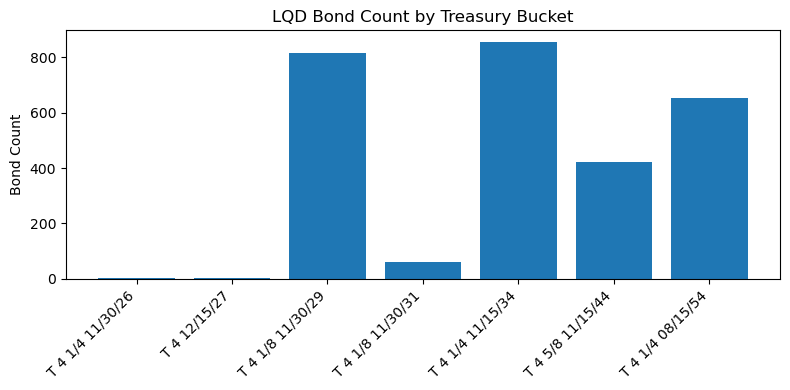

In [27]:
# bond count
plt.figure(figsize=(8,4))
plt.bar(combined['security'], combined['basket_count'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Bond Count')
plt.title('LQD Bond Count by Treasury Bucket')
plt.tight_layout()
plt.show()

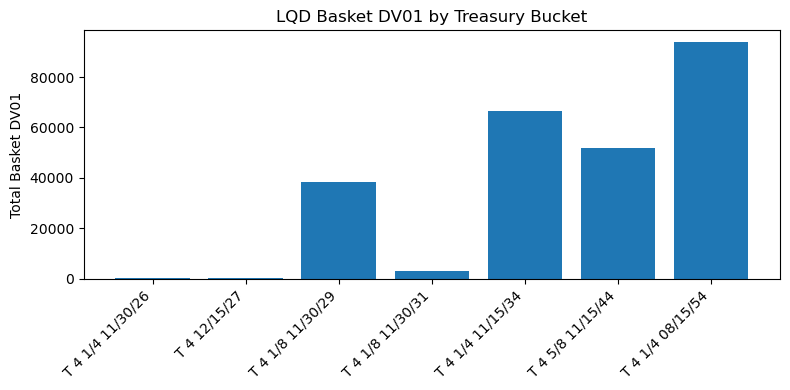

In [28]:
# total basket DV01
plt.figure(figsize=(8,4))
plt.bar(combined['security'], combined['basket_DV01'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Basket DV01')
plt.title('LQD Basket DV01 by Treasury Bucket')
plt.tight_layout()
plt.show()

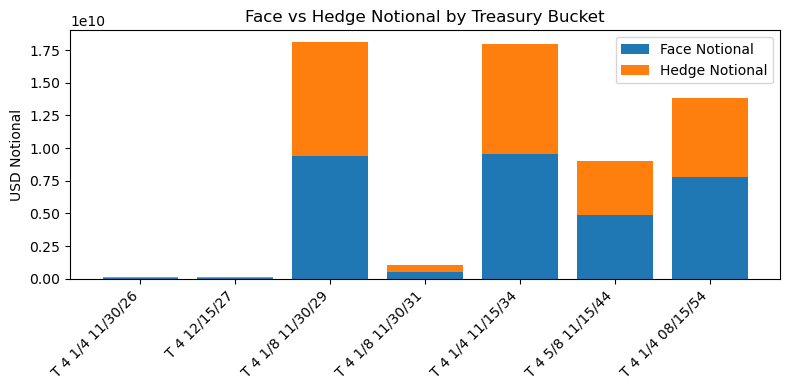

In [29]:
# face notional vs. hedge notional
plt.figure(figsize=(8,4))
x = combined['security']
plt.bar(x, combined['face_notional'], label='Face Notional')
plt.bar(x, combined['basket_hedge_notional'], bottom=combined['face_notional'], label='Hedge Notional')
plt.xticks(rotation=45, ha='right')
plt.ylabel('USD Notional')
plt.title('Face vs Hedge Notional by Treasury Bucket')
plt.legend()
plt.tight_layout()
plt.show()

-----------------------------------------------------------
# Problem 3: CDS Intrinisc Index analysis on CDX IG 5Y


## a. Load and explore the CDX IG 5Y symbology, basket composition and market data

Load the `cdx_symbology` Excel file into a dataframe. Identify the CDX IG 5Y Series 43 index.

Load the `cdx_basket_composition` Excel file into a dataframe. It contains the CDX IG 5Y Series 43 basket composition and CDS Par Spread quotes as of 2024-12-13.

How many CDS contracts are in the CDX index basket? What are the contractual specs and weights of each CDS? Remember that each CDS is identical to the CDX index and the basket has uniform weights.

Compute mean, median and standard deviation of CDS Par Spreads in the basket.

Sort the basket dataframe by CDS Par Spreads and plot the chart of CDS Par Spreads.

In [30]:
cdx_symbology = pd.read_excel("data/cdx_symbology.xlsx", parse_dates=['cpn_first','maturity'])
idx43 = cdx_symbology[cdx_symbology['ticker']=='CDXIG543']
display(idx43)

,symbol,ticker,class,security,name,type,dcc,cpn_first,maturity,currency
8,CDX_CDXIG543,CDXIG543,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.43 12/29,CREDIT DEFAULT SWAP,ACT/360,2024-12-20,2029-12-20,USD


In [31]:
comp = pd.read_excel('data/cdx_ig_43_5y_basket_composition.xlsx',parse_dates=['date'])
comp.head()

,date,index_symbol,index_ticker,index_series,index_weight,ticker,name,seniority,sector,implied_rating,currency,doc_clause,cds_coupon,cds_recovery,cds_par_spread_1y,cds_par_spread_2y,cds_par_spread_3y,cds_par_spread_5y,cds_par_spread_7y,cds_par_spread_10y
0,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,ALLYFI,Ally Finl Inc,SNRFOR,Financials,BB,USD,XR14,100,40,41.1778,66.6848,87.2987,132.0675,174.7143,188.8725
1,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMD,Advanced Micro Devices Inc,SNRFOR,Technology,A,USD,XR14,100,40,13.6814,18.5598,26.1149,37.3970,53.8446,70.1298
2,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMGN,Amgen Inc.,SNRFOR,Healthcare,A,USD,XR14,100,40,11.1293,18.1561,26.0495,41.3471,55.1754,70.5359
3,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMZN,Amazon Com Inc,SNRFOR,Consumer Services,AA,USD,XR14,100,40,9.8157,13.2599,16.5402,22.0839,31.2575,36.9580
4,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,APA,APACHE CORP,SNRFOR,Energy,BB,USD,XR14,100,40,21.9683,37.9983,64.1039,108.1955,140.8867,155.8093


In [32]:
common_cols = set(idx43.columns).intersection(comp.columns)
idx43_trim = idx43.drop(columns=list(common_cols))
comp_merged = comp.merge(idx43_trim, left_on="index_symbol", right_on="symbol", how="inner")
comp_merged.head()

,date,index_symbol,index_ticker,index_series,index_weight,ticker,name,seniority,sector,implied_rating,...,cds_par_spread_5y,cds_par_spread_7y,cds_par_spread_10y,symbol,class,security,type,dcc,cpn_first,maturity
0,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,ALLYFI,Ally Finl Inc,SNRFOR,Financials,BB,...,132.0675,174.7143,188.8725,CDX_CDXIG543,Curncy,MARKIT CDX IG,CREDIT DEFAULT SWAP,ACT/360,2024-12-20,2029-12-20
1,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMD,Advanced Micro Devices Inc,SNRFOR,Technology,A,...,37.3970,53.8446,70.1298,CDX_CDXIG543,Curncy,MARKIT CDX IG,CREDIT DEFAULT SWAP,ACT/360,2024-12-20,2029-12-20
2,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMGN,Amgen Inc.,SNRFOR,Healthcare,A,...,41.3471,55.1754,70.5359,CDX_CDXIG543,Curncy,MARKIT CDX IG,CREDIT DEFAULT SWAP,ACT/360,2024-12-20,2029-12-20
3,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMZN,Amazon Com Inc,SNRFOR,Consumer Services,AA,...,22.0839,31.2575,36.9580,CDX_CDXIG543,Curncy,MARKIT CDX IG,CREDIT DEFAULT SWAP,ACT/360,2024-12-20,2029-12-20
4,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,APA,APACHE CORP,SNRFOR,Energy,BB,...,108.1955,140.8867,155.8093,CDX_CDXIG543,Curncy,MARKIT CDX IG,CREDIT DEFAULT SWAP,ACT/360,2024-12-20,2029-12-20


In [33]:
comp = comp_merged.copy()
num_contracts = len(comp)
print(f"Number of CDS contracts: {num_contracts}\n")

specs = comp[['ticker','name','seniority','sector','implied_rating','currency','doc_clause','cds_coupon','cds_recovery','index_weight']]
display(specs.head())

Number of CDS contracts: 125



,ticker,name,seniority,sector,implied_rating,currency,doc_clause,cds_coupon,cds_recovery,index_weight
0,ALLYFI,Ally Finl Inc,SNRFOR,Financials,BB,USD,XR14,100,40,0.8
1,AMD,Advanced Micro Devices Inc,SNRFOR,Technology,A,USD,XR14,100,40,0.8
2,AMGN,Amgen Inc.,SNRFOR,Healthcare,A,USD,XR14,100,40,0.8
3,AMZN,Amazon Com Inc,SNRFOR,Consumer Services,AA,USD,XR14,100,40,0.8
4,APA,APACHE CORP,SNRFOR,Energy,BB,USD,XR14,100,40,0.8


In [34]:
ps = comp['cds_par_spread_5y']
print("5Y CDS Par Spread (bps)")
print(f"mean = {ps.mean():.2f}")
print(f"median = {ps.median():.2f}")
print(f"std = {ps.std():.2f}")

5Y CDS Par Spread (bps)
mean = 50.71
median = 42.14
std = 26.02


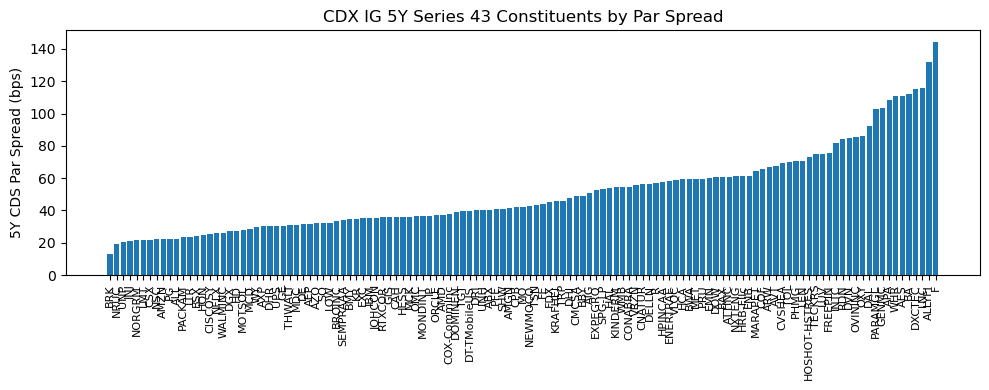

In [35]:
comp_sorted = comp.sort_values('cds_par_spread_5y')

plt.figure(figsize=(10,4))
plt.bar(comp_sorted['ticker'], comp_sorted['cds_par_spread_5y'])
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('5Y CDS Par Spread (bps)')
plt.title('CDX IG 5Y Series 43 Constituents by Par Spread')
plt.tight_layout()
plt.show()

## b. Calibrate the US SOFR yield curve (via bootstrapping)
Load the `sofr_swap_symbology` Excel file into a dataframe.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe.

Follow Homework 4, Problem 2 and calibrate the SOFR discount curve as of 2024-12-13.

In [36]:
sofr_sym = pd.read_excel('data/sofr_swaps_symbology.xlsx')
tenors = sorted(sofr_sym['tenor'].unique())

sofr_mkt = pd.read_excel('data/sofr_swaps_market_data_eod.xlsx')
sofr_mkt['date'] = pd.to_datetime(sofr_mkt['date'])

sofr_df = (sofr_sym.merge(sofr_mkt, on='figi', how='inner').query("date == '2024-12-13'").copy())

sofr_curve = calibrate_sofr_curve_from_frame(calc_date,sofr_df,rate_quote_column='midRate')

grid_dates = [sofr_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]
sofr_yield_curve_df = get_yield_curve_details_df(sofr_curve, grid_dates)
display(sofr_yield_curve_df)

,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2026-12-16,2.028,0.923,4.052
2,2028-12-16,4.058,0.855,3.946
3,2030-12-16,6.086,0.792,3.897
4,2032-12-16,8.117,0.734,3.892
5,2034-12-16,10.144,0.678,3.899
6,2036-12-16,12.175,0.627,3.905
7,2038-12-16,14.203,0.580,3.912
8,2040-12-16,16.233,0.536,3.918
9,2042-12-16,18.261,0.495,3.925


## c. Compute the intrinsic Premium Leg PV of the CDX index basket

Follow Homework 4, Problem 3. 

For each instrument in the basket, create the CDS object. 

Use the calibrated SOFR discount curve and the CDS Par Spreads to calibrate the individual hazard rate / survival probability curves.

Compute the Premium Leg PV for each CDS and aggregate the intrinsic Premium Leg PV of the basket (using basket weights).

Plot the Premium Leg PVs for individual CDS constituents.

In [37]:
sofr_yc_handle = ql.YieldTermStructureHandle(sofr_curve) 

idx_row = idx43.iloc[0]
maturity = idx_row['maturity']    
mat = ql.Date(maturity.day, maturity.month, maturity.year)

tenor_cols = [
    'cds_par_spread_1y','cds_par_spread_2y','cds_par_spread_3y',
    'cds_par_spread_5y','cds_par_spread_7y','cds_par_spread_10y'
]

pvs, w_pvs = [], []

for _, r in comp.iterrows():
    par_spreads = [float(r[c]) for c in tenor_cols]
    recovery = float(r['cds_recovery']) / 100.0
    weight = float(r['index_weight'])

    hazard_curve = calibrate_cds_hazard_rate_curve(
        calc_date,
        sofr_yc_handle,
        par_spreads,
        cds_recovery_rate=recovery
    )
    hazard_handle = ql.DefaultProbabilityTermStructureHandle(hazard_curve)

    sched = ql.MakeSchedule(
        effectiveDate = calc_date,
        terminationDate = mat,
        tenor = ql.Period(3, ql.Months),
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond),
        convention = ql.Unadjusted,
        terminalDateConvention = ql.Unadjusted,
        rule  = ql.DateGeneration.TwentiethIMM,
        firstDate = ql.Date(),
        endOfMonth = False,
        nextToLastDate=ql.Date()
    )

    cds = ql.CreditDefaultSwap(
        ql.Protection.Buyer,            
        100.0,
        r['cds_coupon'] / 10000.0,
        sched,
        ql.Following,
        ql.Actual360()
    )

    engine = ql.MidPointCdsEngine(
        hazard_handle,
        recovery,
        sofr_yc_handle,
    )
    cds.setPricingEngine(engine)

    pv_pl = cds.couponLegNPV()
    pvs.append(pv_pl)
    w_pvs.append(pv_pl * weight)

comp['PV_PremiumLeg'] = pvs
comp['Weighted_PV_Premium'] = w_pvs

Intrinsic Premium Leg PV of CDX IG 5Y Series 43 basket = 452.80 USD


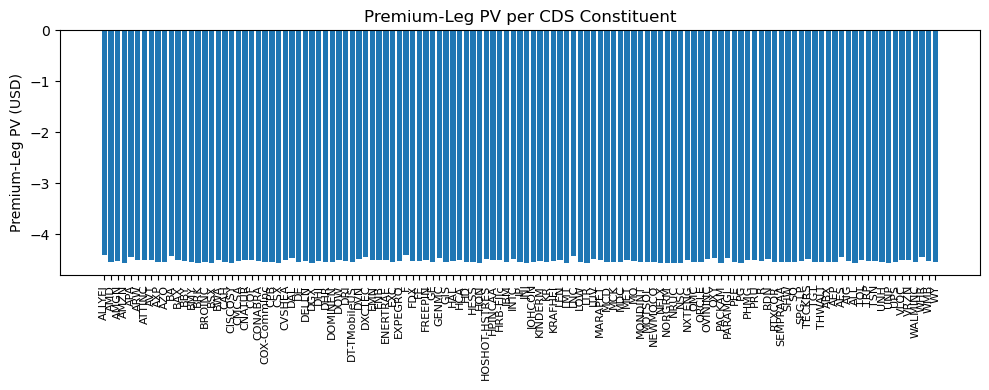

In [38]:
intrinsic_pv = sum(w_pvs)
print(f"Intrinsic Premium Leg PV of CDX IG 5Y Series 43 basket = {-intrinsic_pv:,.2f} USD")

plt.figure(figsize=(10,4))
plt.bar(comp['ticker'], comp['PV_PremiumLeg'])
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Premium‐Leg PV (USD)')
plt.title('Premium‐Leg PV per CDS Constituent')
plt.tight_layout()
plt.show()

## d. Compute the intrinsic Default Leg PV of the CDX index basket

Compute the Default Leg PV for each CDS and determine the intrinsic Default Leg PV of the basket (using basket weights).

Plot the Default Leg PVs for individual CDS constituents.

In [39]:
dl_pvs, w_dl_pvs = [], []

for _, r in comp.iterrows():
    par_spreads = [float(r[c]) for c in tenor_cols]
    recovery = float(r['cds_recovery']) / 100.0
    weight = float(r['index_weight'])

    hazard_curve = calibrate_cds_hazard_rate_curve(
        calc_date,
        sofr_yc_handle,
        par_spreads,
        cds_recovery_rate = recovery
    )
    hazard_handle = ql.DefaultProbabilityTermStructureHandle(hazard_curve)

    sched = ql.MakeSchedule(
        effectiveDate = calc_date,
        terminationDate = mat,
        tenor = ql.Period(3, ql.Months),
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond),
        convention = ql.Unadjusted,
        terminalDateConvention = ql.Unadjusted,
        rule  = ql.DateGeneration.TwentiethIMM,
        firstDate = ql.Date(),
        endOfMonth = False,
        nextToLastDate=ql.Date()
    )

    cds = ql.CreditDefaultSwap(
        ql.Protection.Buyer,
        100.0,
        r['cds_coupon']/10000.0,
        sched,
        ql.Following,
        ql.Actual360()
    )

    engine = ql.MidPointCdsEngine(
        hazard_handle,
        recovery,
        sofr_yc_handle
    )
    cds.setPricingEngine(engine)

    pv_dl = pv_dl =  cds.defaultLegNPV()
    dl_pvs.append(pv_dl)
    w_dl_pvs.append(pv_dl * weight)

comp['PV_DefaultLeg'] = dl_pvs
comp['Weighted_PV_Default'] = w_dl_pvs

Intrinsic Default Leg PV of CDX IG 5Y Series 43 basket = 228.37 USD


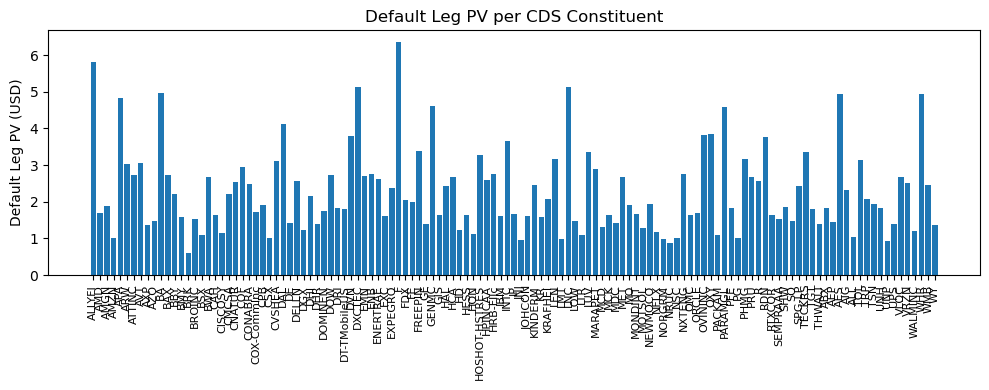

In [40]:
intrinsic_default_pv = sum(w_dl_pvs)
print(f"Intrinsic Default Leg PV of CDX IG 5Y Series 43 basket = {intrinsic_default_pv:,.2f} USD")

plt.figure(figsize=(10,4))
plt.bar(comp['ticker'], comp['PV_DefaultLeg'])
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Default Leg PV (USD)')
plt.title('Default Leg PV per CDS Constituent')
plt.tight_layout()
plt.show()

## e. Compute the intrinsic PV and Par Spread of the CDX index basket

Compute the intrinsic index PV. 

Compute the CDX instrinsic index Par Spread (using ratio of CDX default vs premium legs).

For comparison, plot the CDS PVs for individual CDS constituents.

In [41]:
total_pv_pl = comp['Weighted_PV_Premium'].sum()
total_pv_dl = comp['Weighted_PV_Default'].sum()

intrinsic_index_pv = -total_pv_pl - total_pv_dl
intrinsic_par_spread_bps = total_pv_dl / (-total_pv_pl) * 1e2

print(f"Intrinsic Index PV (USD) = {intrinsic_index_pv:,.2f}")
print(f"Intrinsic Index Par Spread (bps) = {intrinsic_par_spread_bps:.2f}")

Intrinsic Index PV (USD) = 224.43
Intrinsic Index Par Spread (bps) = 50.43


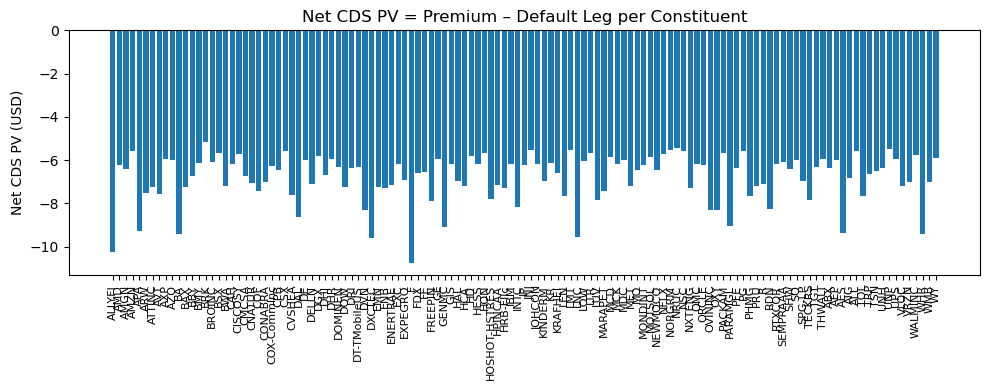

In [42]:
comp['PV_CDS_Net'] = comp['PV_PremiumLeg'] - comp['PV_DefaultLeg']

plt.figure(figsize=(10, 4))
plt.bar(comp['ticker'], comp['PV_CDS_Net'])
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Net CDS PV (USD)')
plt.title('Net CDS PV = Premium – Default Leg per Constituent')
plt.tight_layout()
plt.show()

-----------------------------------------------------------
# Problem 4: PCA curve shape analysis of historical US SOFR OIS rates


## a. Load and explore US SOFR swaps extended symbology and market data

Load the `sofr_swap_symbology_ext` Excel file into a dataframe. List all available swap tenors.

Load the `sofr_swaps_market_data_eod_ext` Excel file into a dataframe. 

Plot the historial time series of SOFR rates for the available swap tenors.

In [43]:
sofr_swap_symbology_ext = pd.read_excel("data/sofr_swaps_symbology_ext.xlsx")
print("Available SOFR Swap Tenors:")
tenors = sorted(sofr_swap_symbology_ext['tenor'].unique())
print(tenors)

Available SOFR Swap Tenors:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]


In [44]:
sofr_swaps_market_data_eod_ext = pd.read_excel("data/sofr_swaps_market_data_eod_ext.xlsx",parse_dates=['date'])
display(sofr_swaps_market_data_eod_ext.head())

,date,figi,bidRate,askRate,midRate
0,2018-01-02,BBG00KFWPKD2,2.1232,2.1597,2.14145
1,2018-01-02,BBG00KFWPKF0,2.1386,2.2008,2.16970
2,2018-01-02,BBG00KFWPKG9,2.1579,2.1913,2.17460
3,2018-01-02,BBG00KFWPKH8,2.1220,2.2024,2.16220
4,2018-01-02,BBG00KFWPJJ9,1.6992,1.7450,1.72210


<Figure size 1000x600 with 0 Axes>

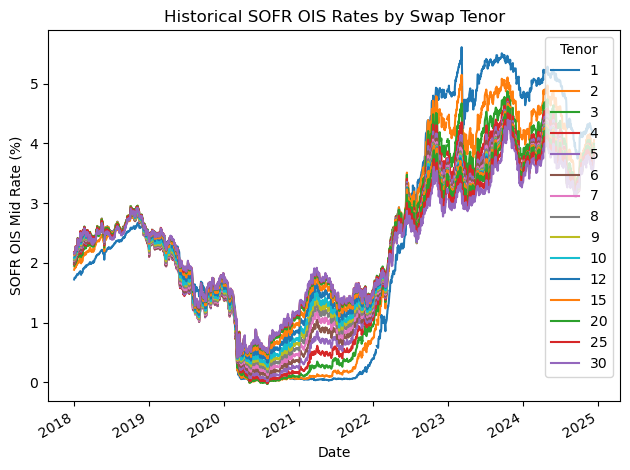

In [45]:
merged = sofr_swaps_market_data_eod_ext.merge(sofr_swap_symbology_ext[['figi', 'tenor']],on='figi',how='inner')
pivot = merged.pivot(index='date', columns='tenor', values='midRate')

# historical SOFR OIS mid rates by tenor
plt.figure(figsize=(10, 6))
pivot.plot()
plt.xlabel("Date")
plt.ylabel("SOFR OIS Mid Rate (%)")
plt.title("Historical SOFR OIS Rates by Swap Tenor")
plt.legend(title="Tenor")
plt.tight_layout()
plt.show()

## b. Run PCA analysis of SOFR OIS rate curves in level space

Run PCA analysis of SOFR OIS rates.

Display and plot the (factor loadings of the) first 3 principal components.

Extract the explained variance ratios for the first 5 principal components and add the cumulative explained variance ratio. Plot the results using a bar plot.

How much explanatory power is captured in the first 3 principal components?

Plot historical PCA scores (factor levels) forresponding to the first 3 principal components.

You can use PCA from sklearn.decomposition, or any other equivalent package.

In [46]:
pivot = pivot.dropna()
X = pivot.values
tenors = pivot.columns.astype(str).tolist()

pca = PCA(n_components=5)
scores = pca.fit_transform(X)
loadings = pca.components_        # shape (5, n_tenors)
explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()

ev_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(5)],
    'ExplainedVariance': explained,
    'CumulativeVariance': cumulative
})
display(ev_df)

,PC,ExplainedVariance,CumulativeVariance
0,PC1,0.984490,0.984490
1,PC2,0.012548,0.997038
2,PC3,0.002757,0.999795
3,PC4,0.000115,0.999911
4,PC5,0.000072,0.999983


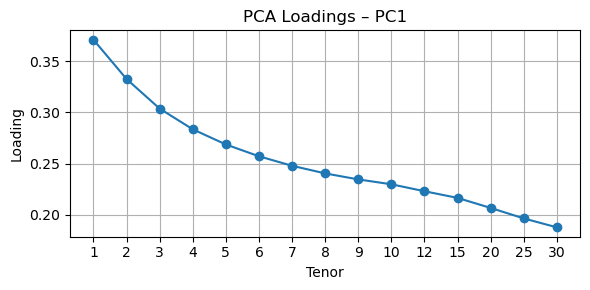

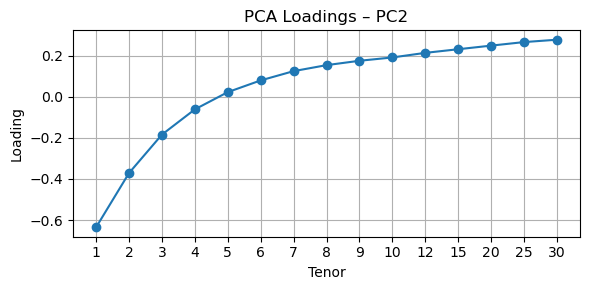

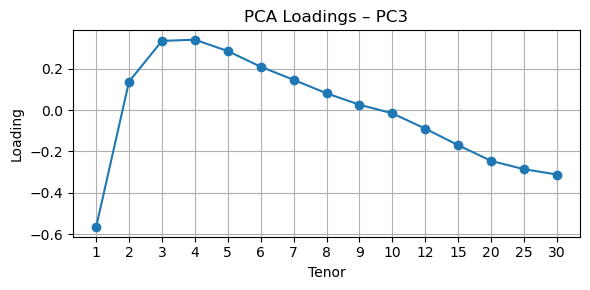

In [47]:
for i in range(3):
    plt.figure(figsize=(6,3))
    plt.plot(tenors, loadings[i], marker='o')
    plt.title(f'PCA Loadings – PC{i+1}')
    plt.xlabel('Tenor')
    plt.ylabel('Loading')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

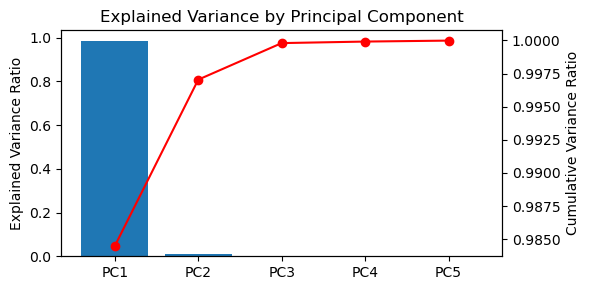

Variance explained by first 3 PCs: 99.98%


In [48]:
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(ev_df['PC'], ev_df['ExplainedVariance'])
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance by Principal Component')
ax2 = ax.twinx()
ax2.plot(ev_df['PC'], ev_df['CumulativeVariance'], color='red', marker='o')
ax2.set_ylabel('Cumulative Variance Ratio')
plt.tight_layout()
plt.show()

print(f"Variance explained by first 3 PCs: {cumulative[2]:.2%}")

<Figure size 1000x400 with 0 Axes>

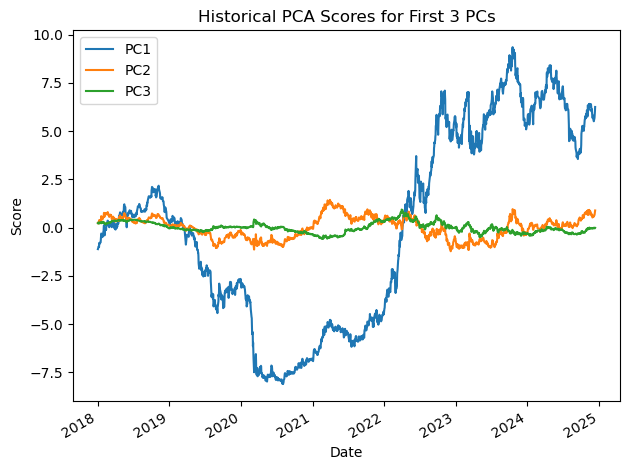

In [49]:
scores_df = pd.DataFrame(scores[:, :3], index=pivot.index, columns=['PC1','PC2','PC3'])
plt.figure(figsize=(10,4))
scores_df.plot()
plt.title('Historical PCA Scores for First 3 PCs')
plt.xlabel('Date')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

## c. Run PCA analysis of SOFR OIS rate curves in (daily) differences space

Repeat the PCA analysis from b. in daily difference space.


In [50]:
diff_rates = pivot.diff().dropna()

X_diff = diff_rates.values
tenors = diff_rates.columns.astype(str).tolist()

pca_diff = PCA(n_components=5)
scores_diff = pca_diff.fit_transform(X_diff)
loadings_diff = pca_diff.components_
explained_diff = pca_diff.explained_variance_ratio_
cumulative_diff = explained_diff.cumsum()

ev_diff_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_diff))],
    'ExplainedVariance': explained_diff,
    'CumulativeVariance': cumulative_diff
})
display(ev_diff_df)

,PC,ExplainedVariance,CumulativeVariance
0,PC1,0.886458,0.886458
1,PC2,0.088779,0.975238
2,PC3,0.014185,0.989423
3,PC4,0.003087,0.992510
4,PC5,0.002390,0.994900


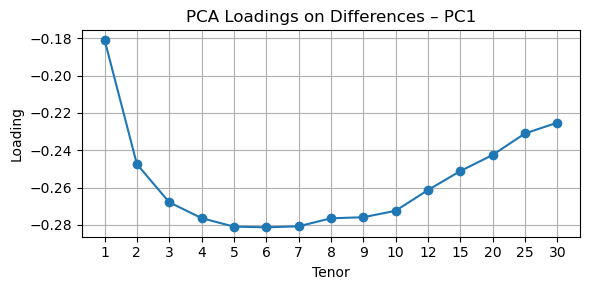

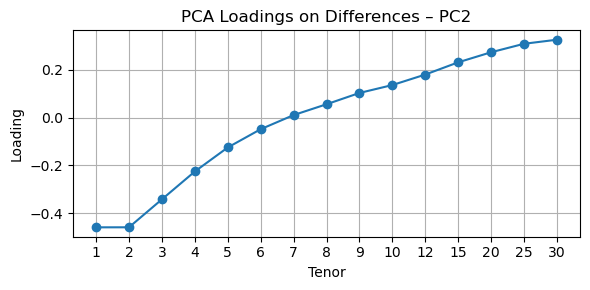

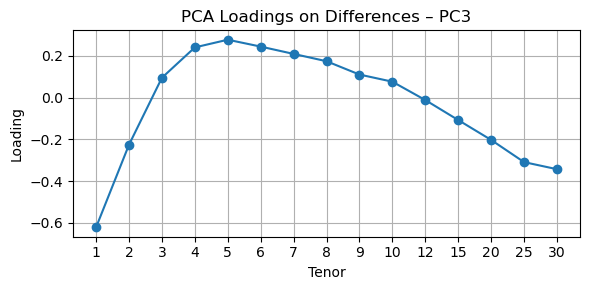

In [51]:
for i in range(3):
    plt.figure(figsize=(6,3))
    plt.plot(tenors, loadings_diff[i], marker='o')
    plt.title(f'PCA Loadings on Differences – PC{i+1}')
    plt.xlabel('Tenor')
    plt.ylabel('Loading')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

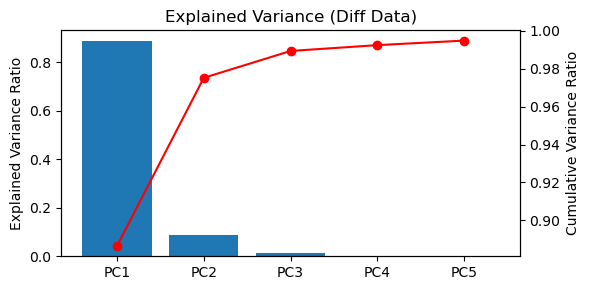

Variance explained by first 3 PCs (differences): 98.94%


In [52]:
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(ev_diff_df['PC'], ev_diff_df['ExplainedVariance'])
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance (Diff Data)')
ax2 = ax.twinx()
ax2.plot(ev_diff_df['PC'], ev_diff_df['CumulativeVariance'], color='red', marker='o')
ax2.set_ylabel('Cumulative Variance Ratio')
plt.tight_layout()
plt.show()

print(f"Variance explained by first 3 PCs (differences): {cumulative_diff[2]:.2%}")

<Figure size 1000x400 with 0 Axes>

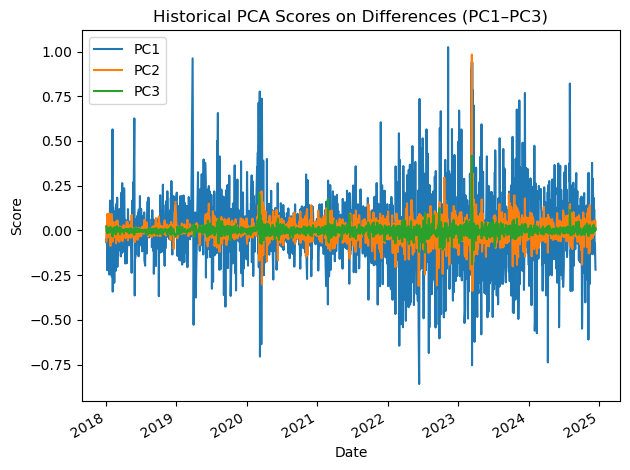

In [53]:
scores_diff_df = pd.DataFrame(scores_diff[:, :3], index=diff_rates.index, columns=['PC1','PC2','PC3'])
plt.figure(figsize=(10,4))
scores_diff_df.plot()
plt.title('Historical PCA Scores on Differences (PC1–PC3)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

## d. Intuitive interpretation of PC1, PC2 and PC3 and connection to the Nelson-Siegel model

Identify and interpret the curve shapes of the top 3 first principal components. 

Do you see any connection to the Nelson-Siegel model curve shapes?

### PC1: Level 
- Almost flat: all tenors have large, positive and nearly equal loadings
- Captures parallel shifts in the entire curve. When PC1 increases, every tenor rises by roughly the same amount.
- This is the dominant mode, explaining often > 90% of the variance in the dataset
- Level: A constant factor adding the same amount at all maturities.

### PC2: Slope
- Positive loading at short tenors, crossing through zero, then negative at long tenors.
- Captures steepening/flattening: if PC2 rises, short rates rise while long rates fall, tilting the curve up at the front end and down at the back end (or vice versa).
- Slope: Loading that decays exponentially, weighting short maturities more.

### PC3: Curvature
- Small at the very short and long ends, largest (positive or negative) at intermediate tenors (e.g. 2–5 years).
- Captures the hump or dip in the mid‐term: increasing PC3 accentuates a hump or belly around the middle of the curve, bending the curve’s shoulders.
- Curvature: A loading that peaks at a finite decay parameter λ, creating a bell‐shape.

### Use
- Dimensionality reduction: Over 95 % of the total variance is typically captured by just these three factors.
- Risk: Traders and risk managers can monitor PC1 to track overall level risk, PC2 for slope risk (e.g. steepener/flattenener trades), and PC3 for curvature risk (e.g. butterfly trades).  
- Model calibration: The similarity between PCA loadings and Nelson Siegel basis functions justifies using NS, or its refinements, for curve fitting and forecasting, with β₀, β₁, β₂ corresponding directly to these risk factors.